# California housing prices
This notebook is based on Chapter 2 of the book **Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow**. We are going it step by step:
1. Frame the problem
2. Get the data
3. Explore the data to gain
4. Prepare data to better expose the underlying data patters to the algorithm
5. Explore many model and shortlist the best ones
6. Fine-tune your model and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain the system


[Dataset](https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv)  
[California shapefile](https://data.ca.gov/dataset/ca-geographic-boundaries)

## Frame the problem and look at the big picture

Our task is to use California census data to build a amodel of housing prices in the state.

Our dataset includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit. What's this mean? Street, buildings, districts?

Our model should learn from this data and be able to predict the **median house price** in aany block, given all the other metrics. They expect a number from a set of inputs. 

So, our dataset is labeled (supervised learning), the prediction is a continuous value (regression task) and we will use multiple features to make a prediction (multivariable).

Decision made, our next step is to select a performance measure. The Root Mean Square Error (RMSE) or Mean Square Error (MSE) are good selection. We will take the first one.

## Get the data

In [1]:
import os
import pandas as pd

# Read the csv and create a DataFrame
df = pd.read_csv(os.path.join("datasets", "california-housing-prices.csv"))
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


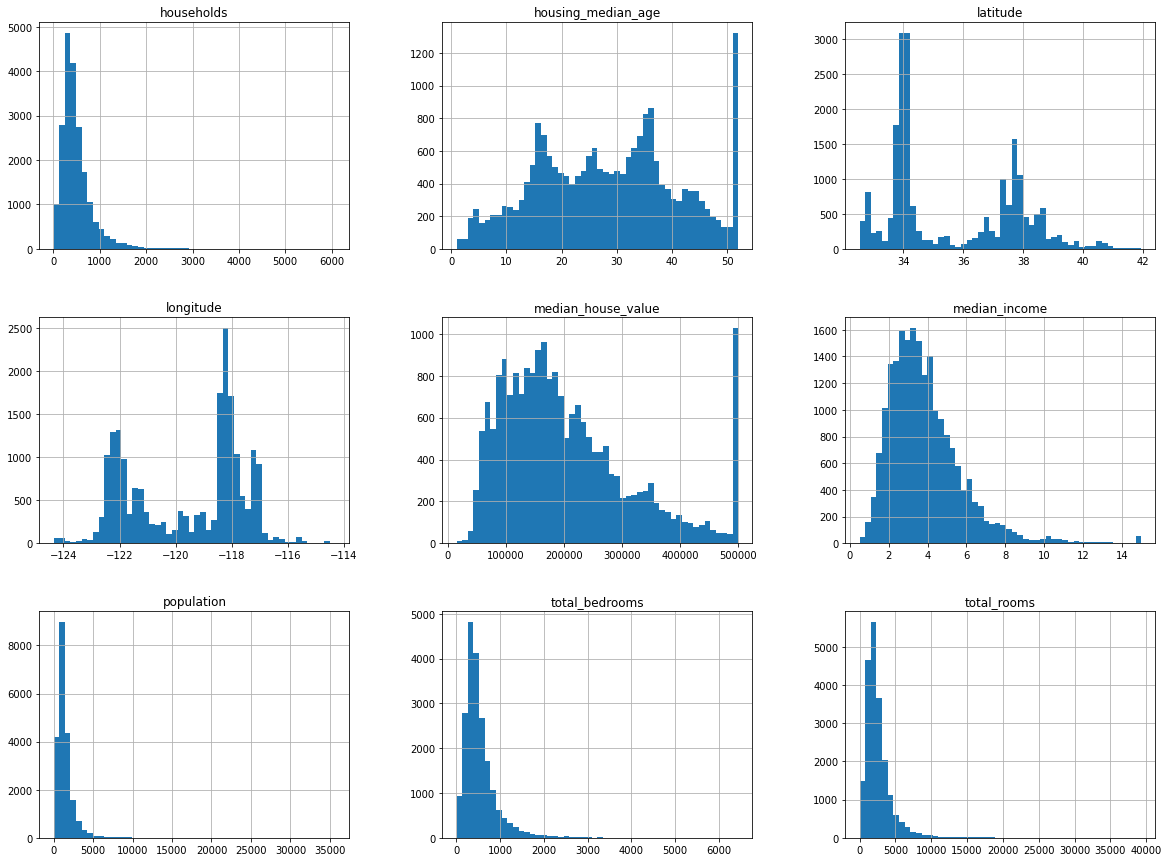

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

First comments:
* There are 20640 instances.
* There are 10 columns. All of them are numbers except ocean_proximity.
* total_bedrooms has null values, we have to take care of them.
* housing_median_age and median_house_value are truncated in 50 years and 500K dollars.
* median_income are expressed in thousand dollars. The maximum value is 15.
* Many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some ML algorithms to detect patterns.
* The attributes have very different scales

### Train and test set

Before starting to analyze and visualize in more detail our dataset, we have to split it. Something important here is to select enough instance on each type or types to not skewed the train and test set. This is called **stratified sampling**, where the population is divided into homogeneous subgroups called strat, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. Suppose experts of the company told to us that the median income is a very important attribute to predict median housing prices. So, we have to make sure we have a fair sample of all median income. 

In [6]:
import numpy as np
# Firstly we are going to create strat, adding a new series to the DataFrame
df["income_cat"] = pd.cut(df["median_income"],
                         bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                         labels=[1, 2, 3, 4, 5])
df["income_cat"].value_counts()/len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

We want to preserve this proportions on our splited sets.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# 20% of the dataset, and set a seed to get always the same instance on each execution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [8]:
# Comparing proportions
compare_props = pd.DataFrame({
    "Overall": df["income_cat"].value_counts()/len(df),
    "Stratified": strat_test_set["income_cat"].value_counts()/len(strat_test_set),
}).sort_index()
compare_props

,Overall,Stratified
1,0.039826,0.039729
2,0.318847,0.318798
3,0.350581,0.350533
4,0.176308,0.176357
5,0.114438,0.114583


In [9]:
# Remove the series created in stratified sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
strat_train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [11]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


## Discover and Visualize the Data to Gain Insights

In [12]:
housing = strat_train_set.copy()

We have geographical information, it is a good idea to create a map with all the district information. For that, we want to compare cities (a group of districts) by population, etc. to try to visualize a possible correlation.

In [13]:
import geopandas as gpd

# To visualize we have to create a GeoDataFrame
gdf = gpd.GeoDataFrame(housing,
                       crs="epsg:4327",
                       geometry=gpd.points_from_xy(housing["longitude"], housing["latitude"]))
gdf["geometry"].head()

17606    POINT (-121.89000 37.29000)
18632    POINT (-121.93000 37.05000)
14650    POINT (-117.20000 32.77000)
3230     POINT (-119.61000 36.31000)
3555     POINT (-118.59000 34.23000)
Name: geometry, dtype: geometry

In [14]:
# Load california state shapefile
california_state = gpd.read_file(os.path.join("maps", "california_state.shp")).to_crs(epsg=4327)
california_state["geometry"].head()

0    MULTIPOLYGON (((-119.63473 33.26545, -119.6363...
Name: geometry, dtype: geometry

In [15]:
# Load california cities shapefile
california_cities = gpd.read_file(os.path.join("maps", "california_places.shp")).to_crs(epsg=4327)
print(california_cities.shape)
california_cities["geometry"].head()

(1522, 17)


0    POLYGON ((-118.45602 34.28491, -118.45415 34.2...
1    POLYGON ((-123.03513 38.78701, -123.03511 38.7...
2    POLYGON ((-122.72961 38.33349, -122.72953 38.3...
3    MULTIPOLYGON (((-119.29712 34.34464, -119.2970...
4    POLYGON ((-117.89111 34.14581, -117.89065 34.1...
Name: geometry, dtype: geometry

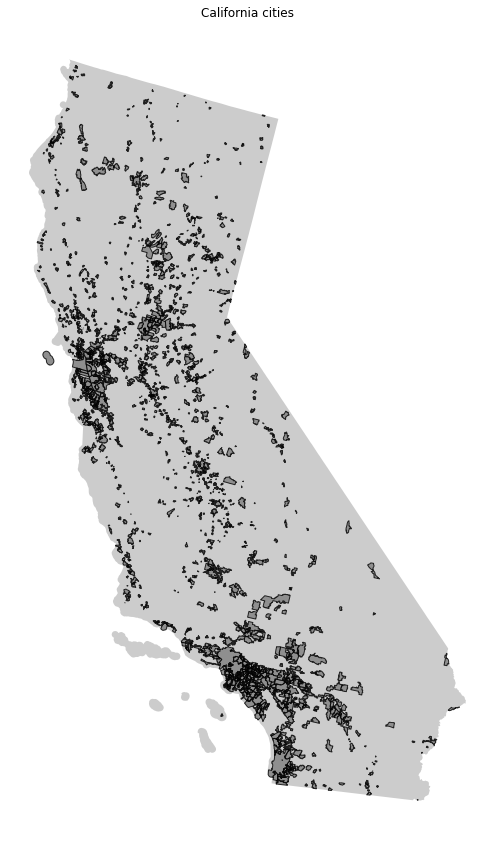

In [16]:
ax = california_state.to_crs(epsg=5071).plot(figsize=(15,15), color="gray", alpha=0.4)
ax.set_axis_off()
california_cities.to_crs(epsg=5071).plot(ax=ax, color="gray", alpha=0.8, edgecolor="black")
plt.title("California cities")
plt.show()

Firstly, we have to join the dataframes. Secondly, group by population.

In [17]:
# Spartial join (remember check CRS)
joined = gpd.sjoin(california_cities, gdf, how="left", op="contains")
joined.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,...,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,...,-118.43,34.30,33.0,2443.0,498.0,1601.0,484.0,4.0223,146000.0,<1H OCEAN
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,...,-118.44,34.28,37.0,944.0,244.0,1107.0,235.0,1.9688,144100.0,<1H OCEAN
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,...,-118.44,34.28,38.0,1156.0,305.0,1359.0,289.0,2.5147,137100.0,<1H OCEAN
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,...,-118.45,34.28,38.0,1527.0,332.0,1303.0,340.0,3.5714,152000.0,<1H OCEAN
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,...,-118.45,34.28,36.0,2602.0,638.0,2780.0,620.0,2.7155,149800.0,<1H OCEAN


In [18]:
joined_groupby_name = joined.groupby(joined["NAME"]).sum()
california_cities.set_index("NAME", inplace=True)
california_cities["population"] = joined_groupby_name["population"]
california_cities[["population"]].sort_values(
    ["population"], ascending=False)

,population
NAME,
Los Angeles,2672726.0
San Diego,842459.0
San Jose,608377.0
San Francisco,546531.0
Long Beach,302895.0
...,...
Jenner,0.0
Johannesburg,0.0
Johnsville,0.0


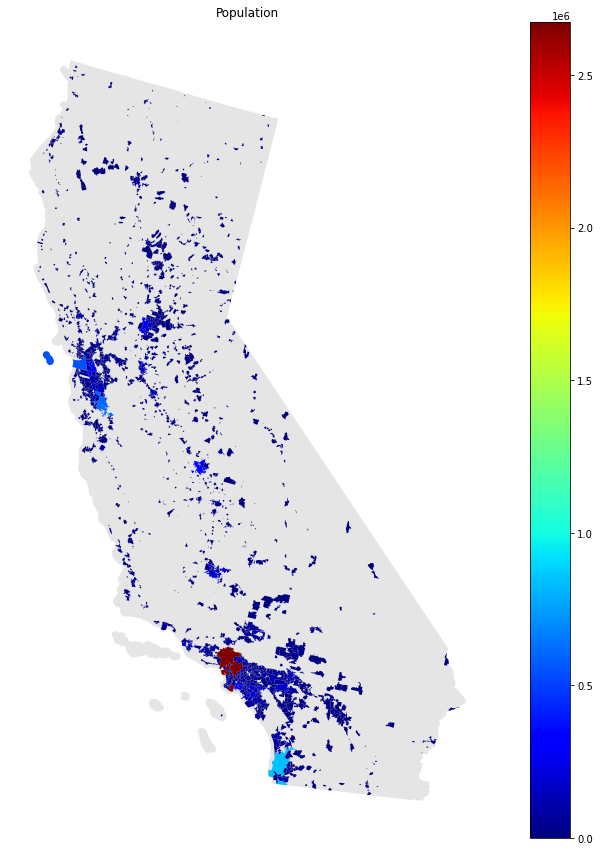

In [19]:
ax = california_state.to_crs(epsg=5071).plot(figsize=(15,15), color="grey", alpha=0.2)
ax.set_axis_off()
california_cities.to_crs(epsg=5071).plot(ax=ax, legend=True,
                       column="population", cmap="jet")
plt.title("Population")
plt.show()

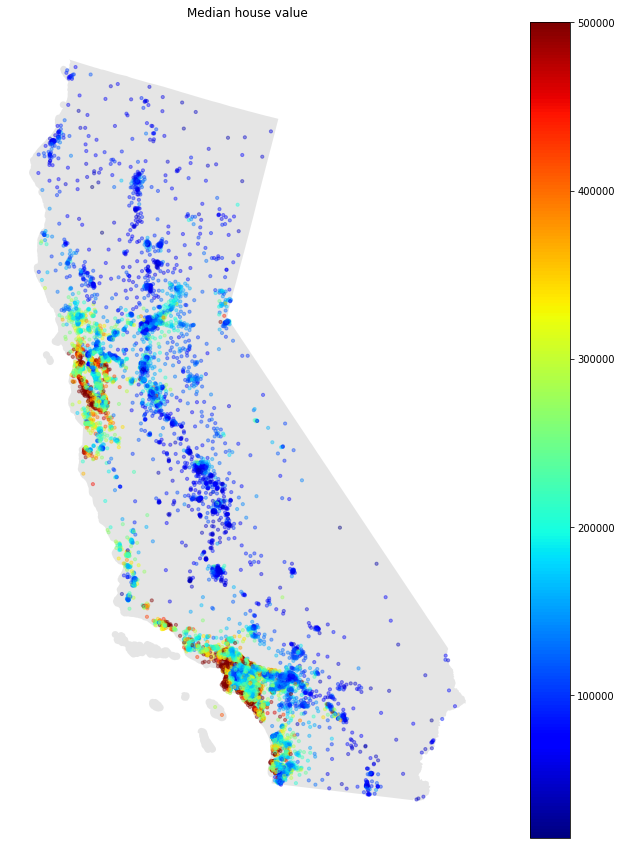

In [20]:
# Create houses lat/lng visualization
ax = california_state.to_crs(epsg=5071).plot(figsize=(15,15), color="grey", alpha=0.2)
ax.set_axis_off()
gdf.to_crs(epsg=5071).plot(ax=ax, legend=True, markersize=10,
                       column="median_house_value", cmap="jet", alpha=0.4)
plt.title("Median house value")
plt.show()

This visualization tells us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density.

### Looking for correlations

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Look, the median house value tends to go up when the median income goes up. Let's plot it.

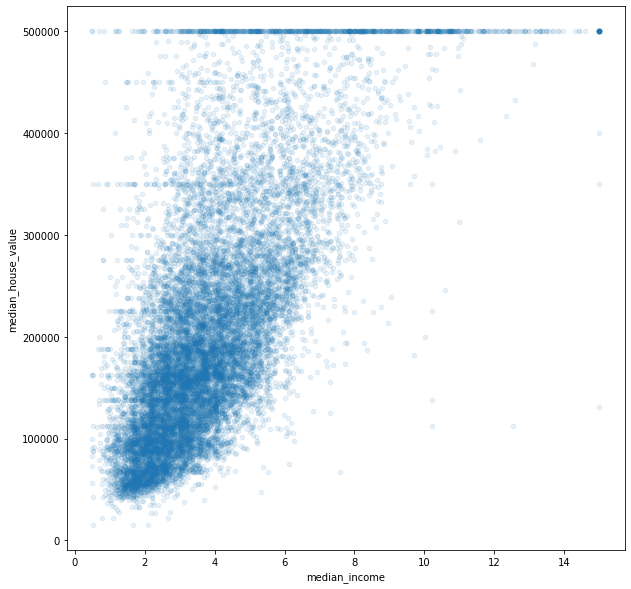

In [22]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10,10))
plt.show()

This plot revails a few things. First, the correlation is indeed wery strong; you can clearly se the upward trend. Second, the price cap that we noticed earlier is clearly visible as horizontal line at 500K, and there are other straight lines around 450K, 350K, 280K, and a few more below. Maybe we want to try removing this district to prevent the algorithm from learning to reproduce these data quirks. 

Before starting to prepare our data, we also could try to generate new attribute combinations.

In [23]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Let's look at the correlation matrix again.

In [24]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The bedroms_per_rooms is much more correlated now. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The rooms_per_household is also more informative than the toal number of rooms, obviously the larger the house, the more expensive they are.

## Prepare teh Data for ML Algorithms

Firstly, let's separate the predictors and the label. We don't necessarily want to apply the same transformation to the predictors and the target values.

In [25]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy() # It create a Series not a DataFrame

Let's work with **numerical attributes**.

We saw earlier that the total_bedrooms attribute has some missing values (most ML algoritms can't work with missing features). We have three options:
* Get rid the corresponding district.
* Get rid the whole attribute
* Set the values to some value (zero, the mean, the median, etc.). Remember to save the value, for the test set an new values

There aren't so many null values, so the median could be a good option.

In [26]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Fit it only on numerical attributes, where we can apply the median
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [28]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
# Transform the trainng set
X = imputer.transform(housing_num)

X is an array, which we have to create a DataFrame

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
# Check where are the impcomplete rows and if it has changed
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


All with the same value: 433.

We can create our own custom transformation. Notice that you have to include fit and transform methods (for Pipelines).

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Finaly, one of the most important transofrmations yo need to apply to your data is **feature scaling**. In general, ML Algorithms don't perform well when the input numerical attributes have very different scales. There are two commons ways to get all attributes to have the same scale: min-max scallling and standardization. Standardization is much less affected by outliers, than min-max scalling.

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(housing_num)
X

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

Now it's time to **text and categorical attributes**. Most ML Algorithms prefer to work with numbers, so let's convert categories to numbers. To do that we use a method call one-hot enconding.

In [33]:
housing_cat = housing[["ocean_proximity"]]
housing_cat["ocean_proximity"].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

The OneHotEnconder needs to fit and transform a DataFrame not a Series.

We could do `housing_cat = housing["ocean_proximity"]`, the syntax is correct but it returns a Series. For this reason we use `housing_cat = housing[["ocean_proximity"]]`

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
# Check the categories found by the enconder
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Transformation Pipelines

In this example we have introduce three tranformation, but we could need many more in ohter dataset. Also, some have to be executed in the right order. Fortunately, Scikit-Learn provided the Pipeline class to help with such sequences. The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps.

It a good practise creates appropiate pipeline for numerical, text and categorical columns.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define columns
num_attribs = list(housing.select_dtypes(include=[np.number]))
cat_attribs = ["ocean_proximity"]

# Numerical Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Categorical Pipeline
cat_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder()),
])

# All Pipelines
full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, num_attribs),
        ("categorical", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [37]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


## Select and Train a Model

This step tries to train and check performance measure in a some models and take the most promising ones. We talked about a supervised learning problem and a regression task. So, we are going to train a:
* Linear Regression
* Decision Tree
* Random Forest

As we define, RMSE will be our perfomance measure and we will evaluate model using cross-validation.

In [38]:
# Create a function to display scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [42]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [69079.85367894 67574.29569854 71151.72167838 69192.90439207
 69953.97087883 76319.37016294 72065.56560867 70620.67713874
 76600.77611591 69549.29073043]
Mean: 71210.8426083453
Standard deviation: 2870.6954217013686


### Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49258.64416298 47679.26617888 49925.84279437 52332.93240994
 49761.20838093 53579.32273958 48851.82285545 48020.11290236
 53272.07850698 50302.90787292]
Mean: 50298.41388043759
Standard deviation: 1984.8946004022312


It needs some time to finish, because trains 10 model.

#### Some comments about underfitting and overfitting

The error lies around 60K-65K, and the most districts' median_house_values range between 120K-265K (percentil 25 and 75), so typical prediction around 60K-65K is not very satisfying. This is a case of a model **underfitting**.

In [45]:
df["median_house_value"].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

On the other hand if we calculate RMSE (without cross-validation) on each model, both calculations should be close. If not, it is an indicator of **overfitting**.

In [46]:
from sklearn.metrics import mean_squared_error

# Calculate predictions
lin_predictions = lin_reg.predict(housing_prepared)

# Calculate RMSE
lin_mse = mean_squared_error(housing_labels, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
abs(lin_rmse - lin_rmse_scores.mean())

424.2631649616087

In [47]:
# Calculate predictions
tree_predictions = tree_reg.predict(housing_prepared)

# Calculate RMSE
tree_mse = mean_squared_error(housing_labels, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
abs(tree_rmse - tree_rmse_scores.mean())

71210.8426083453

In [48]:
# Calculate predictions
forest_predictions = forest_reg.predict(housing_prepared)

# Calculate RMSE
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
abs(forest_rmse - forest_rmse_scores.mean())

31693.58286137753

Finally it's important to save every model you experiment with so that you can come back easily to any model you want. We use .pkl extension (Python Pickle File). We could load by: `model_loaded = joblib.load("filename.pkl")`

In [49]:
import joblib

# Dataset
joblib.dump(housing_prepared, os.path.join("models", "dataset_prepared.pkl"))
joblib.dump(housing_labels, os.path.join("models", "dataset_labels.pkl"))

# Linear Regression
joblib.dump(lin_reg, os.path.join("models", "linear_regression.pkl"))
joblib.dump(lin_predictions, os.path.join("models", "linear_predictions.pkl"))
joblib.dump(lin_scores, os.path.join("models", "linear_scores.pkl"))

# Decision Tree
joblib.dump(tree_reg, os.path.join("models", "tree_regression.pkl"))
joblib.dump(tree_predictions, os.path.join("models", "tree_predictions.pkl"))
joblib.dump(tree_scores, os.path.join("models", "tree_scores.pkl"))

# Random Forest
joblib.dump(forest_reg, os.path.join("models", "forest_regression.pkl"))
joblib.dump(forest_predictions, os.path.join("models", "forest_predictions.pkl"))
joblib.dump(forest_scores, os.path.join("models", "forest_scores.pkl"))

['models/forest_scores.pkl']

## Fine-Tune Your Model

Once we have trained these three model, we need to find the best combination of hyperparameter. We are only going to tune hyperparameters for Random Forest.

In [50]:
from sklearn.model_selection import GridSearchCV

# Combinations
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# Which model tune
forest_reg = RandomForestRegressor()

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

The best hyperparameter combination found:

In [51]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [52]:
# We will use it, not the one that train in the last section!
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [53]:
# Cross-validation error
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results["rmse"] = np.sqrt(-grid_results["mean_test_score"])
grid_results[["rmse", "params"]].sort_values("rmse", ascending=True)

,rmse,params
8,49778.659298,"{'max_features': 6, 'n_estimators': 30}"
11,50201.713614,"{'max_features': 8, 'n_estimators': 30}"
5,50444.643459,"{'max_features': 4, 'n_estimators': 30}"
17,52052.150922,"{'bootstrap': False, 'max_features': 4, 'n_est..."
7,52120.444800,"{'max_features': 6, 'n_estimators': 10}"
10,52305.645020,"{'max_features': 8, 'n_estimators': 10}"
4,52681.212553,"{'max_features': 4, 'n_estimators': 10}"
15,52849.043095,"{'bootstrap': False, 'max_features': 3, 'n_est..."
2,52875.681696,"{'max_features': 2, 'n_estimators': 30}"
13,54179.796815,"{'bootstrap': False, 'max_features': 2, 'n_est..."


Now we have a slightly better score, that we had earlier.

### Analyze the Best Models and Their Errors

We are going to inspect which attributes let the model makes accurate predictions.

In [54]:
# Get array of numbers indicating importances
feature_importances = grid_search.best_estimator_.feature_importances_

# Add names to this values
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# Get ocean_proximity categories
cat_one_hot_attribs = list(full_pipeline.named_transformers_["categorical"].steps[0][1].categories_[0])

# List all sorted
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3281085925627775, 'median_income'),
 (0.17590474543697102, 'INLAND'),
 (0.10841753319430006, 'pop_per_hhold'),
 (0.07474966845209673, 'longitude'),
 (0.06770676899186939, 'latitude'),
 (0.06368572600138235, 'rooms_per_hhold'),
 (0.056538535817258734, 'bedrooms_per_room'),
 (0.043082413380054294, 'housing_median_age'),
 (0.019121369688706247, 'total_rooms'),
 (0.018117350688463065, 'population'),
 (0.016960880820993188, 'total_bedrooms'),
 (0.016304797088876555, 'households'),
 (0.004934749648660887, '<1H OCEAN'),
 (0.0037923881952763587, 'NEAR OCEAN'),
 (0.0024144474998904143, 'NEAR BAY'),
 (0.00016003253242331502, 'ISLAND')]

With this information, you may wanto to try dropping some of the less usefull features. Apparently only INLAND ocean_proximity category is really useful, so you could try dropping the others.

### Evaluate Your System on the Test Set

We have a system that performs sufficiently well. Now is to evaluate the final model on the test set. Be careful not call fit_transform() method, you don't want to fit the test set.

In [55]:
# Take the best model
final_model = grid_search.best_estimator_

# Split sets
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Execute the transformation pipeline
X_test_prepared = full_pipeline.transform(X_test)

# Get predictions over the best train model
final_predictions = final_model.predict(X_test_prepared)

# Calculate performance error
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47896.585680779615

Let's compare both models (training and the grid one) focusing on: max_feature and n_estimators)

In [56]:
grid_model = grid_search.best_estimator_
train_model = forest_reg

print(f"Grid Model (feature/estimators): {grid_model.max_features} / {grid_model.n_estimators} ")
print(f"Train Model (feature/estimators): {train_model.max_features} / {train_model.n_estimators} ")

Grid Model (feature/estimators): 6 / 30 
Train Model (feature/estimators): auto / 100 


Think about these numbers. In the train model section, we didn't change any hyperparameter. So, what did happend? The train model overfitted data. The difference between cross-validation score and RMSE was 30000. Now the difference is only 2000. It's balanced between fitting our dataset and make good predictions from new instances.

## What if we use the most important attributes to train our model?

In [57]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3281085925627775, 'median_income'),
 (0.17590474543697102, 'INLAND'),
 (0.10841753319430006, 'pop_per_hhold'),
 (0.07474966845209673, 'longitude'),
 (0.06770676899186939, 'latitude'),
 (0.06368572600138235, 'rooms_per_hhold'),
 (0.056538535817258734, 'bedrooms_per_room'),
 (0.043082413380054294, 'housing_median_age'),
 (0.019121369688706247, 'total_rooms'),
 (0.018117350688463065, 'population'),
 (0.016960880820993188, 'total_bedrooms'),
 (0.016304797088876555, 'households'),
 (0.004934749648660887, '<1H OCEAN'),
 (0.0037923881952763587, 'NEAR OCEAN'),
 (0.0024144474998904143, 'NEAR BAY'),
 (0.00016003253242331502, 'ISLAND')]

To do that, we have to add a new transformer in the preparation timeline.

In [58]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [59]:
# Number of top features we want to keep
k = 6

# Return the indices of the top k features
top_k_feature_indices = indices_of_top_k(feature_importances, k)

np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'rooms_per_hhold',
       'pop_per_hhold', 'INLAND'], dtype='<U18')

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection.

In [60]:
feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

# Prepare train set
housing_prepared_top_k_features = feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.31205452, -0.08649871,
         0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936,  0.21768338, -0.03353391,
         0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.46531516, -0.09240499,
         0.        ]])

In [61]:
# Train 
forest_top_k_reg = RandomForestRegressor()
forest_top_k_reg.fit(housing_prepared_top_k_features, housing_labels)

# Cross-Validation
forest_top_k_scores = cross_val_score(forest_top_k_reg, housing_prepared_top_k_features, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_top_k_rmse_scores = np.sqrt(-forest_top_k_scores)
display_scores(forest_top_k_rmse_scores)

Scores: [48327.13072835 48718.69673144 50207.64673813 51857.3588106
 47902.57249641 53975.41144852 48187.88683606 48400.64310736
 52233.77795197 49806.46392039]
Mean: 49961.75887692262
Standard deviation: 1974.6017271816158
